In [1]:
!pip install tensorflow_addons

# **Import**

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from collections import Counter
from datetime import datetime
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

tf.get_logger().setLevel('INFO')

c:\Users\PC\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## **Getting Images**

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# IMAGE
RAW_IMG_SIZE = 128
NUM_CLASSES = 268
INPUT_SHAPE = (RAW_IMG_SIZE, RAW_IMG_SIZE, 3)
SPLIT_SEED = 103

# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = RAW_IMG_SIZE
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [6]:
pathh='C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\Veriler\\hepsi\\5\\128'
y_train_aug_le= np.loadtxt(pathh+'/y_train_aug_le.txt', dtype=float)
y_train_aug_cat= np.loadtxt(pathh+'/y_train_aug_cat.txt', dtype=float)
y_val_le= np.loadtxt(pathh+'/y_val_le.txt', dtype=float)
y_val_cat= np.loadtxt(pathh+'/y_val_cat.txt', dtype=float)
y_test_le= np.loadtxt(pathh+'/y_test_le.txt', dtype=float)
y_test_cat= np.loadtxt(pathh+'/y_test_cat.txt', dtype=float)
x_train= np.load(pathh+'/x_train.npy')
x_val= np.load(pathh+'/x_val.npy')
x_test= np.load(pathh+'/x_test.npy')
y_test= np.load(pathh+'/y_test.npy')
y_val= np.load(pathh+'/y_val.npy')
y_train= np.load(pathh+'/y_train.npy')

In [7]:
y_train_aug_cat.shape

(17536, 268)

# **Model**

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.Normalization(),
        layers.Resizing(224, 224),
        # layers.RandomRotation(factor=0.15),
        # layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        # layers.RandomFlip(),
        # layers.RandomContrast(factor=0.01),
    ],
    name="img_augmentation",
)

In [9]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#     print("Device:", tpu.master())
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError:
#     print("Not connected to a TPU runtime. Using CPU/GPU strategy")
#     strategy = tf.distribute.MirroredStrategy()

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

# top3_acc.__name__ = 'top3_acc'

# model.compile('adam', 'categorical_crossentropy', ['accuracy', top3_acc])

inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = img_augmentation(inputs)
outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",  metrics=['accuracy', 'top_k_categorical_accuracy'],
    )

kayit_adresi = "C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\grad_modeller\\EfficentNet-20230521T093806Z-001\\EfficentNet\\model_kayitlari"
if not os.path.exists(kayit_adresi):
    os.mkdir(kayit_adresi)
zaman = datetime.today().strftime('%d-%m-%Y-%H-%M')
model_kayit_noktasi_adresi = os.path.join(kayit_adresi,zaman)
os.mkdir(model_kayit_noktasi_adresi)


# kayit adresleri
checkpoint_filepath  = os.path.join(model_kayit_noktasi_adresi,"model.hdf5")

# CHECKPOINT
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath = checkpoint_filepath,
save_weights_only = True,
monitor='val_accuracy',
save_best_only = True)

# LRR
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',  
factor=.1,  # Factor by which learning rate will be reduced
patience=20,
min_lr=1e-5)
callbacks = [ checkpoint_callback, lrr]

history = model.fit(x=x_train, y=y_train_aug_cat, epochs=EPOCHS, validation_data=(x_val,y_val_cat), callbacks=callbacks)


In [ ]:
model.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test_cat)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

try:
    txt_kayit_adresi    = os.path.join(model_kayit_noktasi_adresi, f"results.txt")
    with open(txt_kayit_adresi, "w") as fh:
        fh.write(f"Epok sayisi: {EPOCHS}\nbasarisi: Test accuracy: {round(accuracy * 100, 2)}\nTop_5_accuracy: {round(top_5_accuracy * 100, 2)}")

except Exception as e2:
    print("Model txt ye yazdirilamadi, hata: ", e2)
    pass

11/11 [==============================] - 1s 28ms/step - loss: 1.0513 - accuracy: 0.8140 - top_k_categorical_accuracy: 0.9451
Test accuracy: 81.4%


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'top_k_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_top_k_categorical_accuracy', 'lr'])

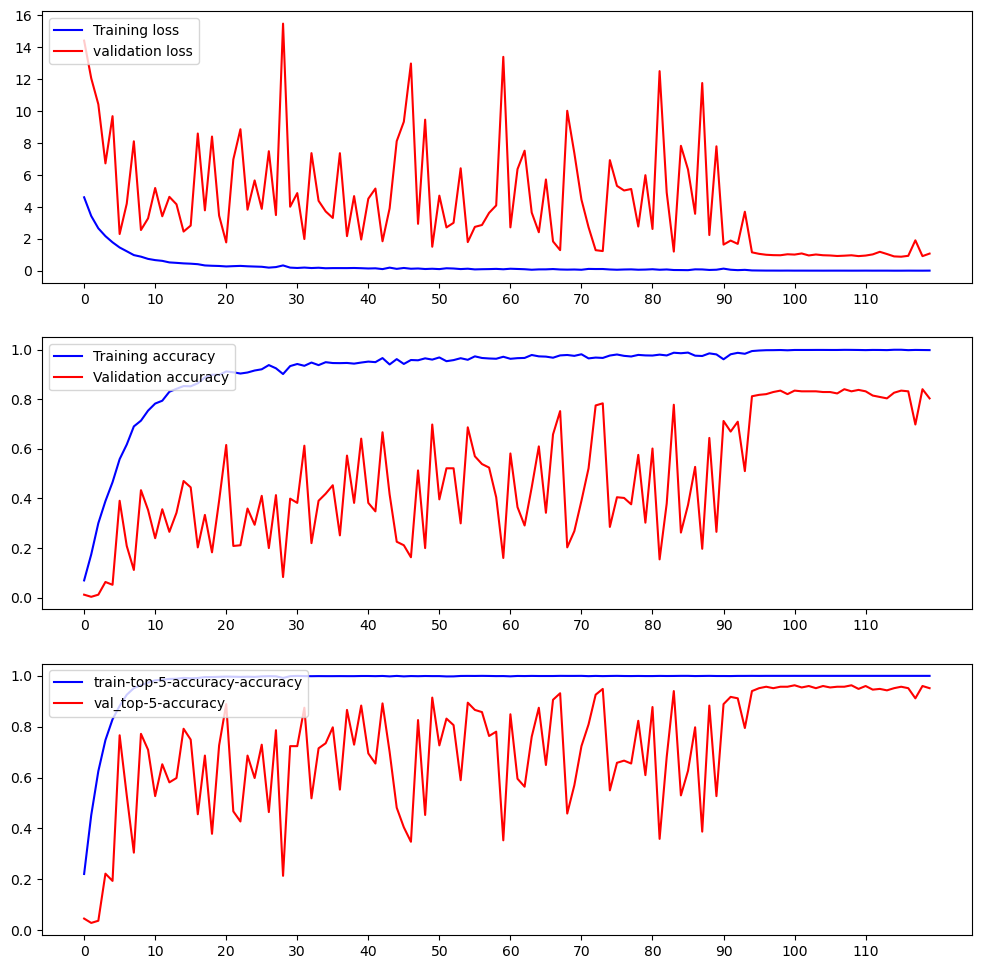

In [ ]:
grafik_adresi = os.path.join(model_kayit_noktasi_adresi, "Grafik.png")

try:
        
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(0, EPOCHS, 10))
    ax1.legend(loc='upper left')

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(0, EPOCHS, 10))
    ax2.legend(loc='upper left')

    ax3.plot(history.history['top_k_categorical_accuracy'], color='b',label="train-top-5-accuracy-accuracy")
    ax3.plot(history.history['val_top_k_categorical_accuracy'], color='r',label="val_top-5-accuracy")
    ax3.set_xticks(np.arange(0, EPOCHS, 10))
    ax3.legend(loc='upper left')
    plt.savefig(grafik_adresi, bbox_inches='tight', facecolor='w')
    plt.show()

except Exception as e:
    print(f"Grafik çizilemedi {e}")

# **Fine Tuning**

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy']
    )
    return model

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

model = build_model(NUM_CLASSES)
unfreeze_model(model)

fine_tune_epochs = 100

kayit_adresi = "/content/drive/MyDrive/ens 492/bitirme/Grad/EfficentNet/model_kayitlari"
if not os.path.exists(kayit_adresi):
    os.mkdir(kayit_adresi)
zaman = datetime.today().strftime('%d-%m-%Y-%H-%M')
model_kayit_noktasi_adresi = os.path.join(kayit_adresi,zaman)
os.mkdir(model_kayit_noktasi_adresi)


# kayit adresleri
checkpoint_filepath  = os.path.join(model_kayit_noktasi_adresi,"fine_tune_model.hdf5")

# CHECKPOINT
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath = checkpoint_filepath,
save_weights_only = True,
monitor='val_accuracy',
save_best_only = True)

# LRR
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',  
factor=.1,  # Factor by which learning rate will be reduced
patience=20,
min_lr=1e-5)
callbacks = [ checkpoint_callback, lrr]

history = model.fit(x=x_train, y=y_train_aug_cat, epochs=fine_tune_epochs, validation_data=(x_val,y_val_cat), callbacks=callbacks)

In [ ]:
model.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test_cat)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

try:
    txt_kayit_adresi    = os.path.join(model_kayit_noktasi_adresi, f"fine_tuning.txt")
    with open(txt_kayit_adresi, "w") as fh:
        fh.write(f"Epok sayisi: {fine_tune_epochs}\nbasarisi: Test accuracy: {round(accuracy * 100, 2)}\nTop_5_accuracy: {round(top_5_accuracy * 100, 2)}")

except Exception as e2:
    print("Model txt ye yazdirilamadi, hata: ", e2)
    pass

In [ ]:
grafik_adresi = os.path.join(model_kayit_noktasi_adresi, "fine_tuning_sonrasi_grafik.png")

try:
        
    fig, (ax1, ax2, ax3) = plt.subplots(2, 1, figsize=(12, 12))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(0, fine_tune_epochs, 10))
    ax1.legend(loc='upper left')

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(0, fine_tune_epochs, 10))
    ax2.legend(loc='upper left')

    ax3.plot(history.history['top_k_categorical_accuracy'], color='b',label="train-top-5-accuracy-accuracy")
    ax3.plot(history.history['val_top_k_categorical_accuracy'], color='r',label="val_top-5-accuracy")
    ax3.set_xticks(np.arange(0, fine_tune_epochs, 10))
    ax3.legend(loc='upper left')
    plt.savefig(grafik_adresi, bbox_inches='tight', facecolor='w')
    plt.show()

except Exception as e:
    print(f"Grafik çizilemedi {e}")